In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


### Calculating the mean and standard deviation to use in normalization. Using both test and train dataset.
Code listed in end of:
https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/39

In [21]:
transform = transforms.Compose([transforms.ToTensor(),])

dataset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=False,transform=transform)
dataset2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,transform=transform)
dataset3 = torch.utils.data.ConcatDataset([dataset1, dataset2])

dataloader = torch.utils.data.DataLoader(dataset3, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print("mean: ", mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print("std: ", std)

0
10000
20000
30000
40000
50000
mean:  tensor([0.4919, 0.4827, 0.4472])
0
10000
20000
30000
40000
50000
std:  tensor([0.2470, 0.2434, 0.2616])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32])
 ship  bird   cat   dog


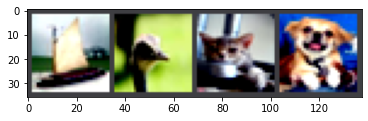

In [4]:
# functions to show an image

def imshow(img):
    #(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    train_loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item()} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item()} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)
    train_accuracy_list.append(100*correct/processed)
  
  print("length of Average loss {}, length of Average accuracy {}".format(len(train_loss_list),len(train_accuracy_list)))
  return train_loss_list, train_accuracy_list


def test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 100: #handtune this for images we need
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print('Test set: Average loss: {:.6f}, Average accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))
    
    return test_loss_list, test_accuracy_list, misclassified_imgs

### Function to create 4 curves - Training loss/accuracy & Test loss/accuracy

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves_all(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


In [6]:
plt.rcParams['figure.figsize'] = [15, 12]

def training_curves(history):
  plt.figure(1)
  plt.plot(np.array(history))
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per epoch")

### Model Net3

In [7]:
dropout_value = 0.0

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        
        # # CONVOLUTION BLOCK 1 changed dilation to 1 in first layer
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same', bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        
        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
            #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation = 1),
            #nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

temp = Net3().to(device)
summary(temp, 
        (3, 32, 32),
        dtypes=[torch.float],
        branching=False,
        verbose=2,
        col_width=16,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

This class will take in the optin of which normalization we would want to use.. 

Group normalization is pending


Input to the architecture is the nrmalization type and input image size

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model = Net3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

model.train()
train_loss = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 12000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss/2000)
            running_loss = 0.0
            
    scheduler.step()
    print("\nlearning rate", optimizer.param_groups[0]['lr'])  

print('Finished Training')

[1,  2000] loss: 2.025
[1,  4000] loss: 1.770
[1,  6000] loss: 1.639
[1,  8000] loss: 1.540
[1, 10000] loss: 1.457
[1, 12000] loss: 1.375

learning rate 0.001
[2,  2000] loss: 1.295
[2,  4000] loss: 1.251
[2,  6000] loss: 1.202
[2,  8000] loss: 1.189
[2, 10000] loss: 1.151
[2, 12000] loss: 1.118

learning rate 0.001
[3,  2000] loss: 1.059
[3,  4000] loss: 1.054
[3,  6000] loss: 1.025
[3,  8000] loss: 1.012
[3, 10000] loss: 0.983
[3, 12000] loss: 0.976

learning rate 0.001
[4,  2000] loss: 0.908
[4,  4000] loss: 0.912
[4,  6000] loss: 0.906
[4,  8000] loss: 0.896
[4, 10000] loss: 0.888
[4, 12000] loss: 0.898

learning rate 0.001
[5,  2000] loss: 0.804
[5,  4000] loss: 0.825
[5,  6000] loss: 0.798
[5,  8000] loss: 0.812
[5, 10000] loss: 0.825
[5, 12000] loss: 0.802

learning rate 0.001
[6,  2000] loss: 0.714
[6,  4000] loss: 0.725
[6,  6000] loss: 0.749
[6,  8000] loss: 0.736
[6, 10000] loss: 0.772
[6, 12000] loss: 0.733

learning rate 0.001
[7,  2000] loss: 0.656
[7,  4000] loss: 0.657


No handles with labels found to put in legend.


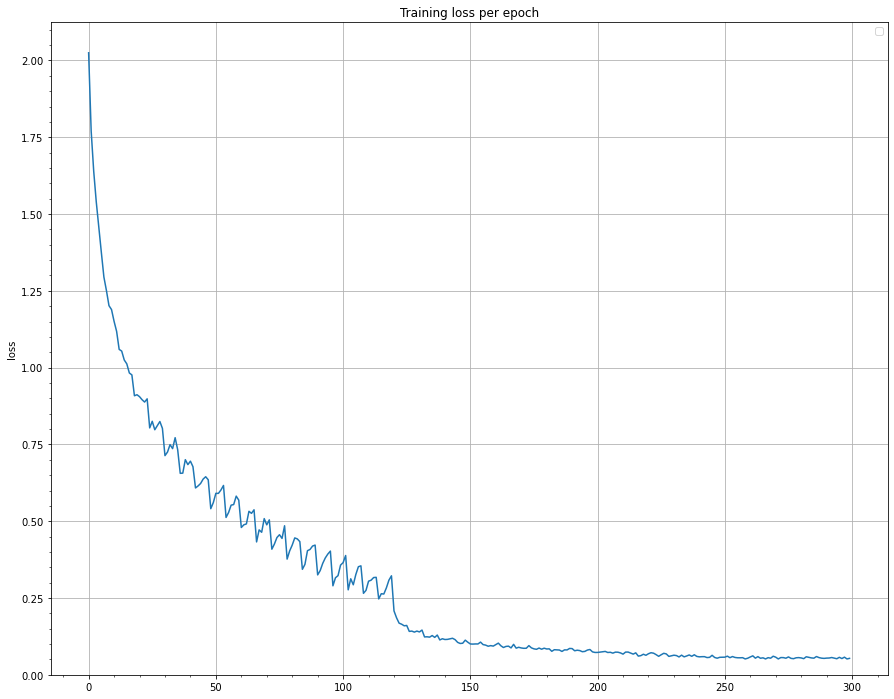

In [10]:
training_curves(train_loss)

In [12]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81 %
Accuracy of   car : 86 %
Accuracy of  bird : 66 %
Accuracy of   cat : 58 %
Accuracy of  deer : 71 %
Accuracy of   dog : 65 %
Accuracy of  frog : 81 %
Accuracy of horse : 78 %
Accuracy of  ship : 84 %
Accuracy of truck : 83 %


In [19]:
dropout_value = 0.0

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        
        # # CONVOLUTION BLOCK 1 changed dilation to 1 in first layer
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same', bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, groups=128, bias=False),
            nn.Conv2d(128,256,1),
            #nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(dropout_value)
        ) # Depthwise
        
        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            # Depthwise
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, groups=128, bias=False),
            nn.Conv2d(128,256,1),
            nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(dropout_value)
        ) # output_size = 7

        
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

temp = Net4().to(device)
summary(temp, 
        (3, 32, 32),
        dtypes=[torch.float],
        branching=False,
        verbose=2,
        col_width=16,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

### Model - Batch Normalization + L1

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model = Net4().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

model.train()
train_loss = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 12000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss/2000)
            running_loss = 0.0
            
    scheduler.step()
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))  

print('Finished Training')

[1,  2000] loss: 2.013
[1,  4000] loss: 1.809
[1,  6000] loss: 1.706
[1,  8000] loss: 1.656
[1, 10000] loss: 1.597
[1, 12000] loss: 1.558

learning rate 0.001
[2,  2000] loss: 1.459
[2,  4000] loss: 1.412
[2,  6000] loss: 1.373
[2,  8000] loss: 1.351
[2, 10000] loss: 1.272
[2, 12000] loss: 1.302

learning rate 0.001
[3,  2000] loss: 1.222
[3,  4000] loss: 1.239
[3,  6000] loss: 1.232
[3,  8000] loss: 1.150
[3, 10000] loss: 1.163
[3, 12000] loss: 1.133

learning rate 0.001
[4,  2000] loss: 1.082
[4,  4000] loss: 1.066
[4,  6000] loss: 1.050
[4,  8000] loss: 1.071
[4, 10000] loss: 1.045
[4, 12000] loss: 1.037

learning rate 0.001
[5,  2000] loss: 0.965
[5,  4000] loss: 0.993
[5,  6000] loss: 0.968
[5,  8000] loss: 0.962
[5, 10000] loss: 0.959
[5, 12000] loss: 0.982

learning rate 0.001
[6,  2000] loss: 0.912
[6,  4000] loss: 0.910
[6,  6000] loss: 0.921
[6,  8000] loss: 0.872
[6, 10000] loss: 0.899
[6, 12000] loss: 0.874

learning rate 0.001
[7,  2000] loss: 0.837
[7,  4000] loss: 0.831


No handles with labels found to put in legend.


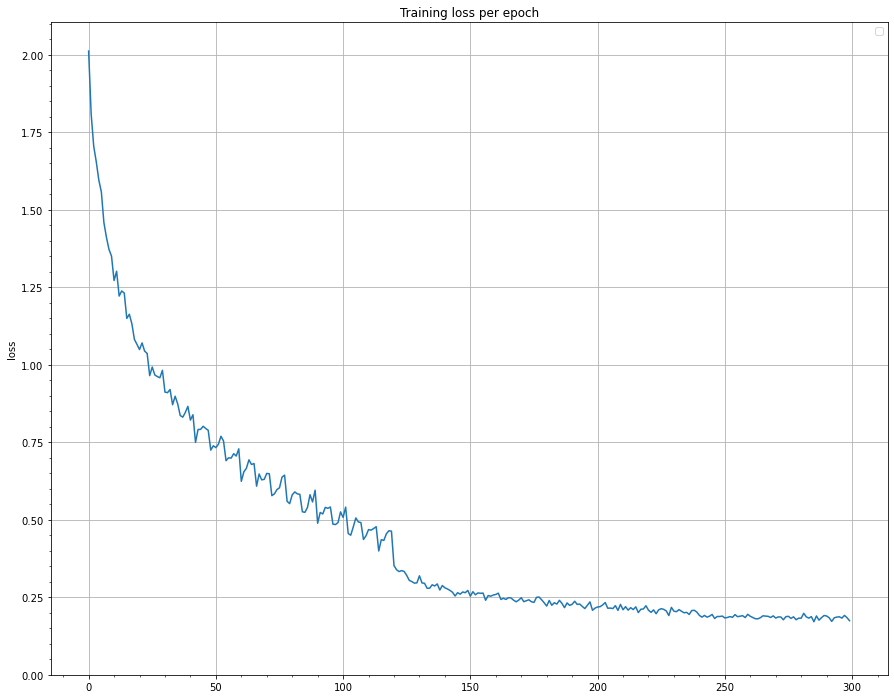

In [22]:
training_curves(train_loss)

In [24]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 64 %
Accuracy of   cat : 59 %
Accuracy of  deer : 77 %
Accuracy of   dog : 64 %
Accuracy of  frog : 83 %
Accuracy of horse : 79 %
Accuracy of  ship : 83 %
Accuracy of truck : 83 %


### Model - Layer Normalization

In [44]:
dropout_value = 0.1

class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        
        # # CONVOLUTION BLOCK 1 changed dilation to 1 in first layer
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same', bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, bias=False, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same', bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, bias=False, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, groups=128, bias=False),
            nn.Conv2d(128,256,1),
            #nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(dropout_value)
        ) # Depthwise
        
        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', bias=False, dilation = 1),
            #nn.ReLU(),
            #nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
            # Depthwise
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, groups=64, bias=False),
            nn.Conv2d(64,128,1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(dropout_value),
            #to remove last fc layer
            nn.Conv2d(128,10,1),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        #self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 10 * 1 * 1)
        return F.log_softmax(x, dim=-1)

temp = Net5().to(device)
summary(temp, 
        (3, 32, 32),
        dtypes=[torch.float],
        branching=False,
        verbose=2,
        col_width=16,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Sequential: 1-1                          --               [-1, 16, 16, 16] --               --
  0.weight                               [16, 3, 3, 3]
  2.weight                               [16]
  4.weight                               [16, 16, 3, 3]
  6.weight                               [16]
  8.weight                               [16, 16, 3, 3]
  10.weight                              [16]
Conv2d: 2-1                              [3, 16, 3, 3]    [-1, 16, 32, 32] 432              442,368
ReLU: 2-2                                --               [-1, 16, 32, 32] --               --
BatchNorm2d: 2-3                         [16]             [-1, 16, 32, 32] 32               16
Dropout: 2-4                             --               [-1, 16, 32, 32] --               --
Conv2d: 2-5                              [16, 16, 3, 3]   [-1, 16, 32, 32] 2,304            2,359,296
ReLU: 2-6  

### Model - Batch Normalization + L1

In [45]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model = Net5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)

model.train()
train_loss = []

for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 12000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss/2000)
            running_loss = 0.0
            
    scheduler.step()
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))  

print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 2.025
[1,  6000] loss: 1.877
[1,  8000] loss: 1.746
[1, 10000] loss: 1.661
[1, 12000] loss: 1.578

learning rate 0.001
[2,  2000] loss: 1.497
[2,  4000] loss: 1.465
[2,  6000] loss: 1.406
[2,  8000] loss: 1.384
[2, 10000] loss: 1.343
[2, 12000] loss: 1.295

learning rate 0.001
[3,  2000] loss: 1.251
[3,  4000] loss: 1.225
[3,  6000] loss: 1.213
[3,  8000] loss: 1.198
[3, 10000] loss: 1.155
[3, 12000] loss: 1.142

learning rate 0.001
[4,  2000] loss: 1.098
[4,  4000] loss: 1.080
[4,  6000] loss: 1.082
[4,  8000] loss: 1.078
[4, 10000] loss: 1.070
[4, 12000] loss: 1.034

learning rate 0.001
[5,  2000] loss: 1.016
[5,  4000] loss: 0.997
[5,  6000] loss: 0.997
[5,  8000] loss: 0.976
[5, 10000] loss: 0.986
[5, 12000] loss: 0.986

learning rate 0.001
[6,  2000] loss: 0.941
[6,  4000] loss: 0.925
[6,  6000] loss: 0.949
[6,  8000] loss: 0.931
[6, 10000] loss: 0.924
[6, 12000] loss: 0.948

learning rate 0.001
[7,  2000] loss: 0.894
[7,  4000] loss: 0.887


[51,  2000] loss: 0.476
[51,  4000] loss: 0.487
[51,  6000] loss: 0.487
[51,  8000] loss: 0.479
[51, 10000] loss: 0.487
[51, 12000] loss: 0.502

learning rate 0.0001
[52,  2000] loss: 0.485
[52,  4000] loss: 0.465
[52,  6000] loss: 0.490
[52,  8000] loss: 0.484
[52, 10000] loss: 0.479
[52, 12000] loss: 0.498

learning rate 0.0001
[53,  2000] loss: 0.482
[53,  4000] loss: 0.473
[53,  6000] loss: 0.471
[53,  8000] loss: 0.498
[53, 10000] loss: 0.477
[53, 12000] loss: 0.494

learning rate 0.0001
[54,  2000] loss: 0.479
[54,  4000] loss: 0.467
[54,  6000] loss: 0.491
[54,  8000] loss: 0.472
[54, 10000] loss: 0.482
[54, 12000] loss: 0.497

learning rate 0.0001
[55,  2000] loss: 0.480
[55,  4000] loss: 0.494
[55,  6000] loss: 0.492
[55,  8000] loss: 0.499
[55, 10000] loss: 0.468
[55, 12000] loss: 0.468

learning rate 0.0001
[56,  2000] loss: 0.481
[56,  4000] loss: 0.478
[56,  6000] loss: 0.492
[56,  8000] loss: 0.480
[56, 10000] loss: 0.512
[56, 12000] loss: 0.461

learning rate 0.0001
[57,

No handles with labels found to put in legend.


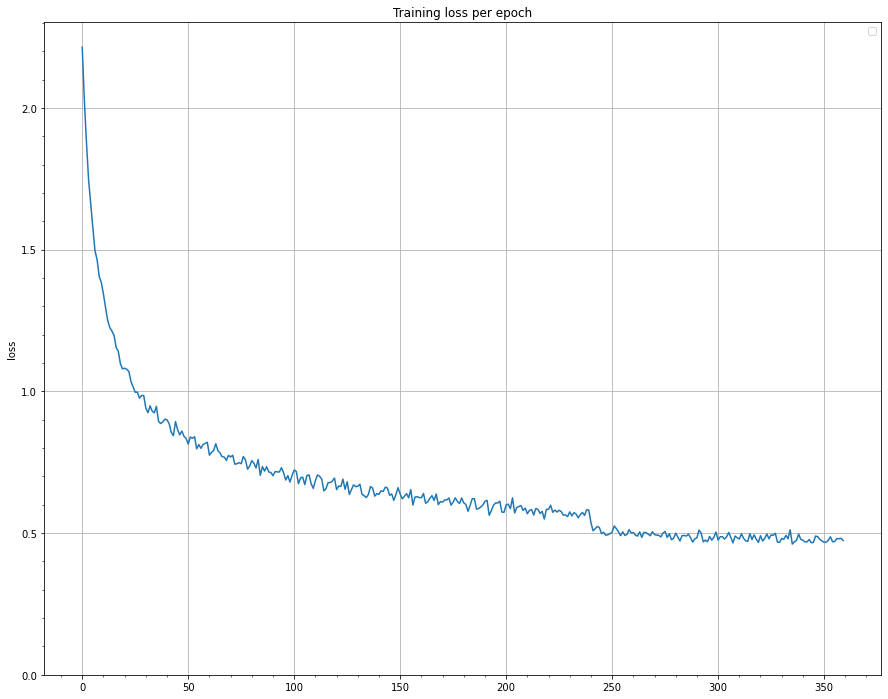

In [46]:
training_curves(train_loss)

In [47]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [48]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 90 %
Accuracy of  bird : 71 %
Accuracy of   cat : 62 %
Accuracy of  deer : 82 %
Accuracy of   dog : 65 %
Accuracy of  frog : 87 %
Accuracy of horse : 82 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %


### Model - Group Normalization 

In [ ]:
training_curves(history)

# Check Misclassified Images

In [54]:
#(0.4919, 0.4827, 0.4472), (0.2470, 0.2434, 0.2616)

def im_unnormalize(img):
  # img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.2470 + 0.4919
    img[1] = img[1]*0.2434 + 0.4827
    img[2] = img[2]*0.2616 + 0.4472
    npimg = img.numpy()
    unnorm_img = np.transpose(npimg, (1, 2, 0))
    return unnorm_img

### L1 + Batch Normalization model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

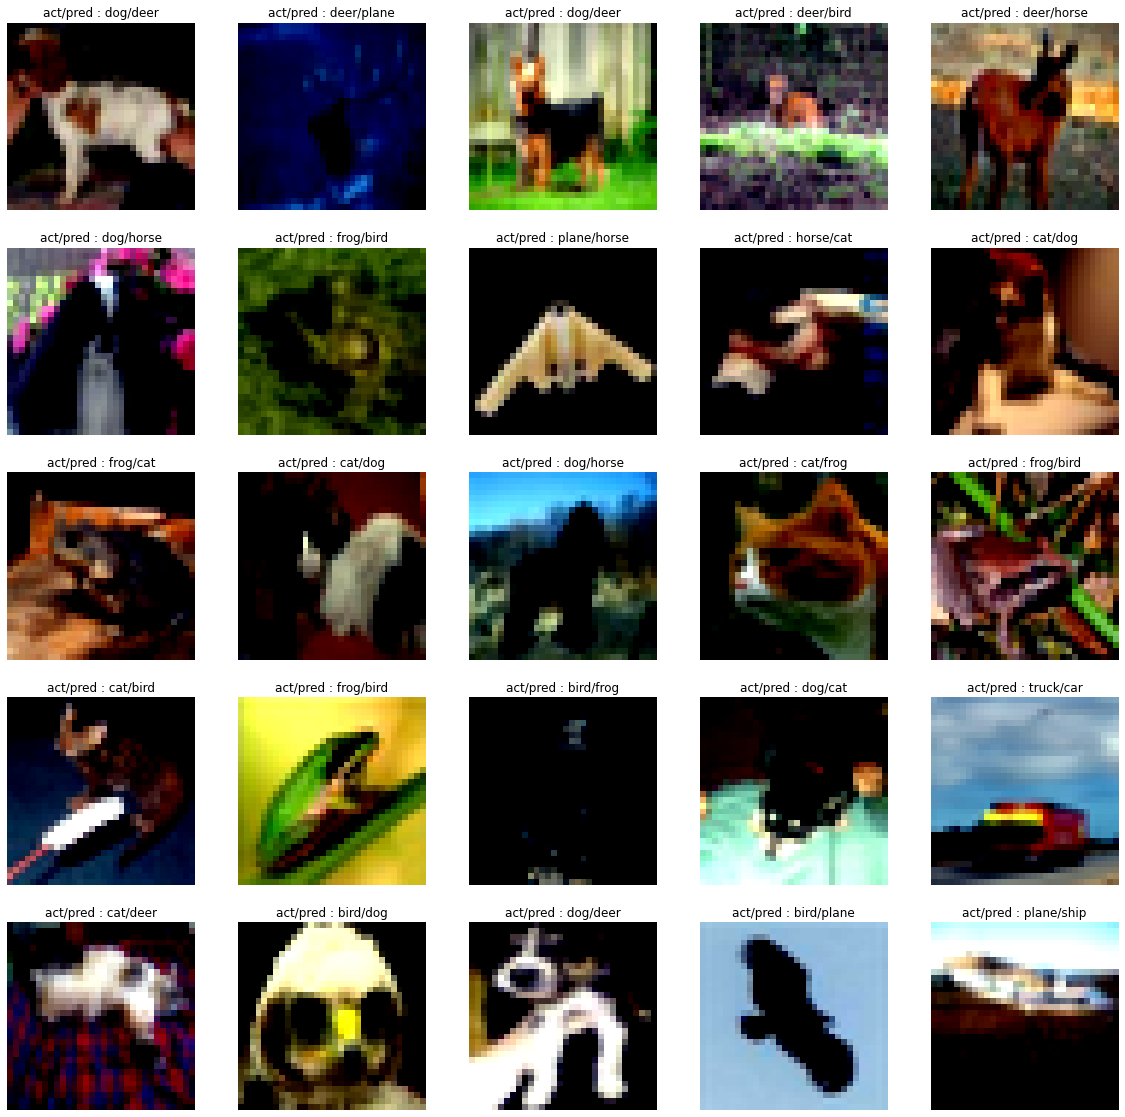

In [55]:
model.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1

### Group Normalization model

In [ ]:
plot_misclassified_images(history['GN_model']['misclassified_imgs'], "misclassified_imgs_GN.png", 20)

### Layer Normalization model

In [ ]:
plot_misclassified_images(history['LN_model']['misclassified_imgs'], "misclassified_imgs_LN.png", 20)